In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# === Load Data ===
data_transaksi = pd.read_csv("data_transaksi.csv")
data_survei = pd.read_csv("data_survei.csv")

print("Contoh Data Transaksi:")
display(data_transaksi.head())

print("Contoh Data Survei:")
display(data_survei.head())

Contoh Data Transaksi:


,tanggal,nama pelanggan,jenis kelamin,tanggal transaksi,layanan yang dipilih,column 6,rating kepuasan,id_transaksi,nama_pelanggan,layanan,harga,rating
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T001,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,22/09/2025 12:20:22,T002,NaN,NaN,NaN,NaN
2,2025-10-31,Adi,Laki-Laki,01/11/2025,"Cukur Jenggot, Cat Rambut",60000.0,3,T003,NaN,NaN,NaN,NaN
3,2025-10-31,putri,Perempuan,31/10/2025,"Hair Spa, Cat Rambut, Creambath",150000.0,3,T004,NaN,NaN,NaN,NaN
4,2025-11-03,NaN,NaN,NaN,NaN,NaN,NaN,T005,putri,"Creambath, Cat Rambut, Hair Spa, Potong Rambut",115000.0,5.0


Contoh Data Survei:


,id_survei,id_transaksi,kepuasan_layanan,kebersihan_tempat,keramahan_karyawan,komentar
0,S001,T001,5,5,4,"Agak lama nunggu, tapi hasilnya bagus."
1,S002,T002,4,4,3,Karyawannya sopan dan teliti.
2,S003,T003,4,4,3,Pelayanannya ramah banget!
3,S004,T004,4,5,5,Tempatnya bersih dan nyaman.
4,S005,T005,3,5,3,"Perlu ditambah kursi tunggu, agak penuh tadi."


Pendapatan Harian:


,tanggal,harga,selisih
0,2025-10-31,0.0,NaN
1,2025-11-03,190000.0,190000.0


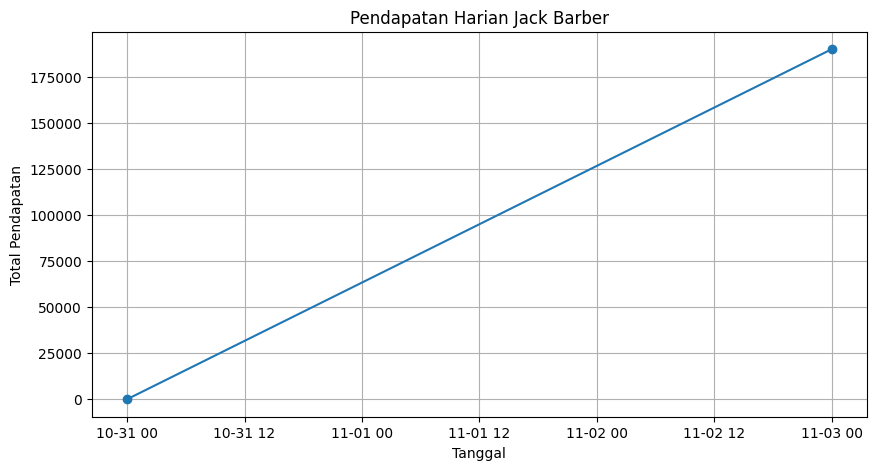

In [3]:
# === Analisis Pendapatan Harian ===
data_transaksi['tanggal'] = pd.to_datetime(data_transaksi['tanggal'])
data_transaksi['harga'] = pd.to_numeric(data_transaksi['harga'], errors='coerce')

pendapatan_harian = data_transaksi.groupby('tanggal')['harga'].sum().reset_index()
pendapatan_harian['selisih'] = pendapatan_harian['harga'].diff()

print("Pendapatan Harian:")
display(pendapatan_harian)

plt.figure(figsize=(10,5))
plt.plot(pendapatan_harian['tanggal'], pendapatan_harian['harga'], marker='o')
plt.title("Pendapatan Harian Jack Barber")
plt.xlabel("Tanggal")
plt.ylabel("Total Pendapatan")
plt.grid(True)
plt.show()

In [4]:
data = pd.merge(data_transaksi, data_survei, on='id_transaksi', how='left')

print("Kolom dalam data:", data.columns.tolist())
print(data.head())


Kolom dalam data: ['tanggal', 'nama pelanggan', 'jenis kelamin', 'tanggal transaksi', 'layanan yang dipilih', 'column 6', 'rating kepuasan', 'id_transaksi', 'nama_pelanggan', 'layanan', 'harga', 'rating', 'id_survei', 'kepuasan_layanan', 'kebersihan_tempat', 'keramahan_karyawan', 'komentar']
     tanggal nama pelanggan jenis kelamin tanggal transaksi  \
0        NaT            NaN           NaN               NaN   
1        NaT            NaN           NaN               NaN   
2 2025-10-31            Adi     Laki-Laki        01/11/2025   
3 2025-10-31          putri     Perempuan        31/10/2025   
4 2025-11-03            NaN           NaN               NaN   

              layanan yang dipilih  column 6      rating kepuasan  \
0                              NaN       NaN                  NaN   
1                              NaN       NaN  22/09/2025 12:20:22   
2        Cukur Jenggot, Cat Rambut   60000.0                    3   
3  Hair Spa, Cat Rambut, Creambath  150000.0        

In [5]:
# === Pastikan ada kolom rating ===
if "rating" not in data.columns:
    if "kepuasan_layanan" in data.columns:
        data["rating"] = data["kepuasan_layanan"]
    elif "nilai_kepuasan" in data.columns:
        data["rating"] = data["nilai_kepuasan"]
    else:
        data["rating"] = 0  # fallback default

# === Pastikan nama pelanggan ada ===
if "nama_pelanggan" not in data.columns:
    if "id_pelanggan" in data.columns:
        data.rename(columns={"id_pelanggan": "nama_pelanggan"}, inplace=True)
    else:
        raise KeyError("Kolom 'nama_pelanggan' tidak ditemukan dalam data.")

# === Clustering Pelanggan ===
df_cluster = data.groupby("nama_pelanggan").agg({
    "harga": "sum",
    "rating": "mean"
}).reset_index()

df_cluster = df_cluster.dropna()


In [6]:
# === Analisis Asosiasi Layanan (Apriori) ===
# Siapkan data transaksi per pelanggan
basket = data.groupby(["nama_pelanggan", "layanan"])['layanan'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

min_support = 0.05
min_conf = 0.4

frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
    print("Aturan Asosiasi Layanan:")
    display(rules.sort_values("confidence", ascending=False))
else:
    print("ℹ️ Tidak ditemukan aturan asosiasi yang memenuhi ambang batas (support/confidence terlalu tinggi).")

Aturan Asosiasi Layanan:


C:\Users\HP\AppData\Local\Temp\ipykernel_18120\3851305668.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
